In [2]:
import pandas as pd
import numpy as np
from scipy.stats import poisson
from matplotlib import pyplot as plt
import datetime
from datetime import timedelta
import seaborn as sns

## Main Fuction to generate Data

This fuction assusmes that 
 - The resource utilization of a service has a poission distribution
 - The mean of this distribution is different during peak hours and non peak hours
 - The services have only one peak hour window

In [5]:
# This fuction is used to create the compute requirements of 
# a service during a day
# It takes in 2 tuples
# hightime: Tuple of lists where each list is start and end of 
#           busytime
# lowtime: Tuple of lists where each list is start and end of 
#           busytime
def dataGen(highTime:list,highTimeMean=70,lowTimeMean=20,workDay=True):
    data = []
    if workDay:
        data+=list(poisson.rvs(mu=lowTimeMean, size=highTime[0]*60)/100)
        data+=list(poisson.rvs(mu=highTimeMean, size=((highTime[1]-highTime[0]+1))*60)/100)
        data+=list(poisson.rvs(mu=lowTimeMean, size=(24-highTime[1]-1)*60)/100)
    else:
        data+=list(poisson.rvs(mu=lowTimeMean, size=24*60)/100)
    return data
    

## How the data will look

In [6]:
data = []
for _ in range(7):
    data+=dataGen([8,17])  # The peak hours are between 8 am and 5pm

In [7]:
synthetic = pd.DataFrame({"Active": data})
synthetic.index = pd.date_range(start="2021-07-01", periods=len(data), freq="min")

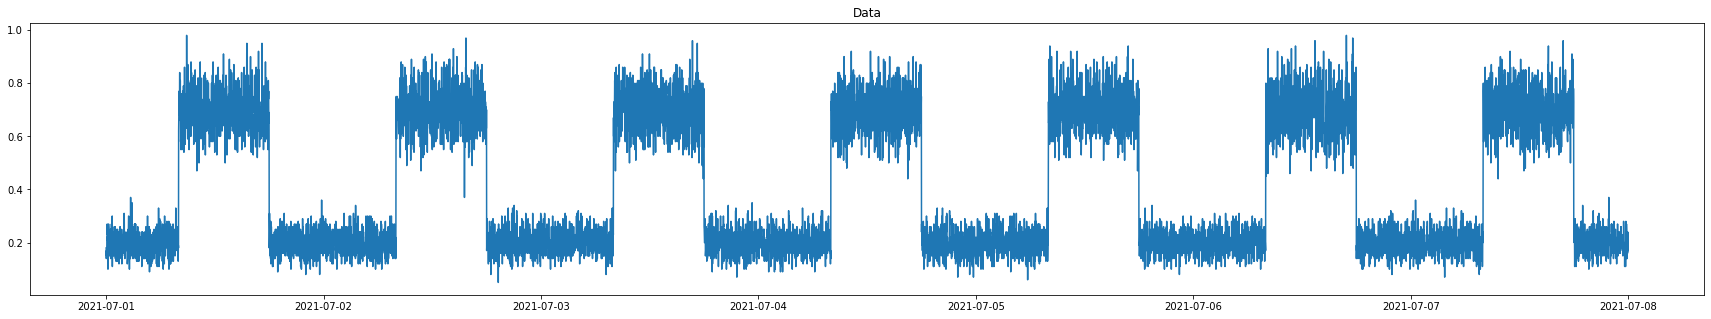

In [8]:
fig = plt.figure(figsize=(30,5))
plt.plot(synthetic.index, synthetic['Active'])
# plt.xticks(rotation=90)
plt.title("Data")
plt.show()

## Dataset with dates

Dataset for a single service generated for 3 years

In [9]:
distriList = []
# date_df = pd.DataFrame({'Date':pd.date_range(start="2021-01-01", end="2022-01-01", freq="D")})
date_df = pd.DataFrame({'Date':pd.date_range(start="2020-01-01", end="2022-01-01", freq="D")})

In [10]:
date_df.shape

(732, 1)

In [11]:
for i in range(len(date_df)):
    if date_df.loc[i,'Date'].strftime('%A') in ['Saturday', 'Sunday']:
        distriList+=dataGen([8,17],workDay=False)
    else:
        distriList+=dataGen([8,17])

In [12]:
# [date.strftime('%A') for date in date_df['Date'][:8]]

In [13]:
# date_df.loc[5,'Date']

In [14]:
len(distriList)

1054080

In [15]:
len(pd.date_range(start="2020-01-01", end="2022-01-02", freq="T")[:-1])

1054080

In [16]:
# dateList = pd.date_range(start="2021-01-01", end="2022-01-02", freq="T")[:-1]
dateList = pd.date_range(start="2020-01-01", end="2022-01-02", freq="T")[:-1]
final_df = pd.DataFrame({"Compute": distriList,'Date:':dateList})
# final_df.index = pd.date_range(start="2021-01-01", end="2022-01-01", freq="min")[:-1]

In [17]:
final_df.set_index('Date:',inplace=True)

In [18]:
final_df

,Compute
Date:,
2020-01-01 00:00:00,0.21
2020-01-01 00:01:00,0.24
2020-01-01 00:02:00,0.31
2020-01-01 00:03:00,0.08
2020-01-01 00:04:00,0.27
...,...
2022-01-01 23:55:00,0.21
2022-01-01 23:56:00,0.14
2022-01-01 23:57:00,0.19


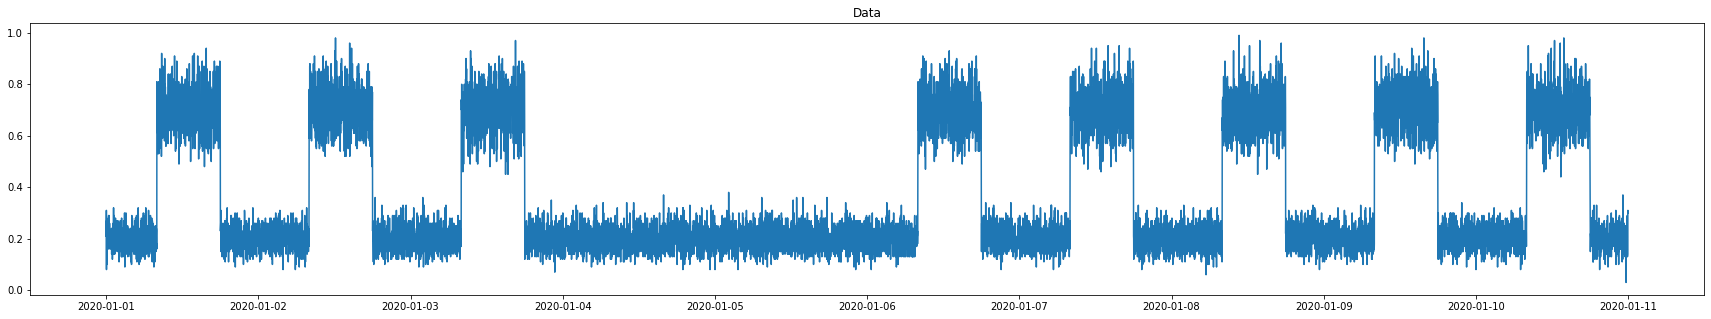

In [19]:
# Plot a part of the data - 10 days
fig = plt.figure(figsize=(30,5))
plt.plot(final_df[:14400].index, final_df[:14400]['Compute'])
# plt.xticks(rotation=90)
plt.title("Data")
plt.show()

## Dataset for Hospital
Lets consider the following services

| Service | Max compute | Lowtime mean | Hightime mean |
| --- | --- | --- | --- |
| Registration | 1 | 20 | 80 |
| Nurse station | 1 | 20 | 80 |
| ED | 1 | 20 | 80 |
| Imaging | 1 | 20 | 80 |
| OR | 1 | 20 | 80 |
| ICU | 1 | 20 | 80 |
| Patient Room | 1 | 20 | 80 |
| Lab | 1 | 20 | 80 |
| Pharmacy | 1 | 20 | 80 |

In [61]:
hospitaf_df = pd.DataFrame({'services':['Registration','Nurse Station','ED','Imaging','OR','ICU','Patient Room','Lab','Pharmacy'],
                            'MaxCompute':[100, 100, 100, 100, 100, 100, 100, 100, 100],
                            'LowtimeMean':[10, 40, 60, 20, 80, 80, 80, 20, 50],
                            'HightimeMean':[80, 80, 80, 80, 80, 80, 80, 80, 80],
                            'Hightime':[[8,17], [8,17], [8,17], [8,17], [8,17], [8,17], [8,17], [12,17], [12,17]]
                           })

In [67]:
hospitaf_df

,services,MaxCompute,LowtimeMean,HightimeMean,Hightime
0,Registration,100,10,80,"[8, 17]"
1,Nurse Station,100,40,80,"[8, 17]"
2,ED,100,60,80,"[8, 17]"
3,Imaging,100,20,80,"[8, 17]"
4,OR,100,80,80,"[8, 17]"
5,ICU,100,80,80,"[8, 17]"
6,Patient Room,100,80,80,"[8, 17]"
7,Lab,100,20,80,"[12, 17]"
8,Pharmacy,100,50,80,"[12, 17]"


## Creating the complete Hospital Dataset

In [63]:
def datasetHelper(df:pd.DataFrame,start="2020-01-01", end="2022-01-01"):
    Final_df = pd.DataFrame(columns=['services', 'Date', 'Compute'])
    for i in range(len(df)):
        distriList = []
        service = [df.loc[i,'services']]
        date_df = pd.DataFrame({'Date':pd.date_range(start=start, end=end, freq="D")})
#         print(len(date_df)*24*60)
        
        for j in range(len(date_df)):
            if date_df.loc[j,'Date'].strftime('%A') in ['Saturday', 'Sunday']:
                distriList+=dataGen(df['Hightime'][i],highTimeMean=df.loc[i,'HightimeMean'],lowTimeMean=df.loc[i,'LowtimeMean'], workDay=False)
            else:
                distriList+=dataGen(df['Hightime'][i], highTimeMean=df.loc[i,'HightimeMean'],lowTimeMean=df.loc[i,'LowtimeMean'])
#         print(start,end)
        newEnd = datetime.datetime.strptime(end, '%Y-%m-%d') + timedelta(days=1)
#         print(newEnd)
        dateList = pd.date_range(start=start, end=newEnd, freq="T")[:-1]
#         print(dateList[:5])
#         print(len(distriList),len(dateList),len([i]*len(distriList)))
        final_df = pd.DataFrame({"Compute": distriList,'Date':dateList,'services':service*len(distriList)})
        
        Final_df = pd.concat([Final_df,final_df])
#         Final_df = pd.merge(Final_df,final_df,on='Date')
    
    Final_df.set_index('Date',inplace=True)
    return Final_df
        
        

In [64]:
def datasetHelper_wide(df:pd.DataFrame,start="2020-01-01", end="2022-01-01"):
    Final_df = pd.DataFrame(columns=['Date'])
    newEnd = datetime.datetime.strptime(end, '%Y-%m-%d') + timedelta(days=1)
    dateList = pd.date_range(start=start, end=newEnd, freq="T")[:-1]
    Final_df['Date'] = dateList
    for i in range(len(df)):
        distriList = []
        service = [df.loc[i,'services']]
        date_df = pd.DataFrame({'Date':pd.date_range(start=start, end=end, freq="D")})

        
        for j in range(len(date_df)):
            if date_df.loc[j,'Date'].strftime('%A') in ['Saturday', 'Sunday']:
                distriList+=dataGen(df['Hightime'][i],highTimeMean=df.loc[i,'HightimeMean'],lowTimeMean=df.loc[i,'LowtimeMean'], workDay=False)
            else:
                distriList+=dataGen(df['Hightime'][i], highTimeMean=df.loc[i,'HightimeMean'],lowTimeMean=df.loc[i,'LowtimeMean'])


        final_df = pd.DataFrame({str(service[0]): distriList,'Date':dateList})
        

        Final_df = pd.merge(Final_df,final_df,on='Date')
    
    Final_df.set_index('Date',inplace=True)
    return Final_df

In [65]:
hospitalDataset = datasetHelper_wide(hospitaf_df)

<AxesSubplot:xlabel='Date'>

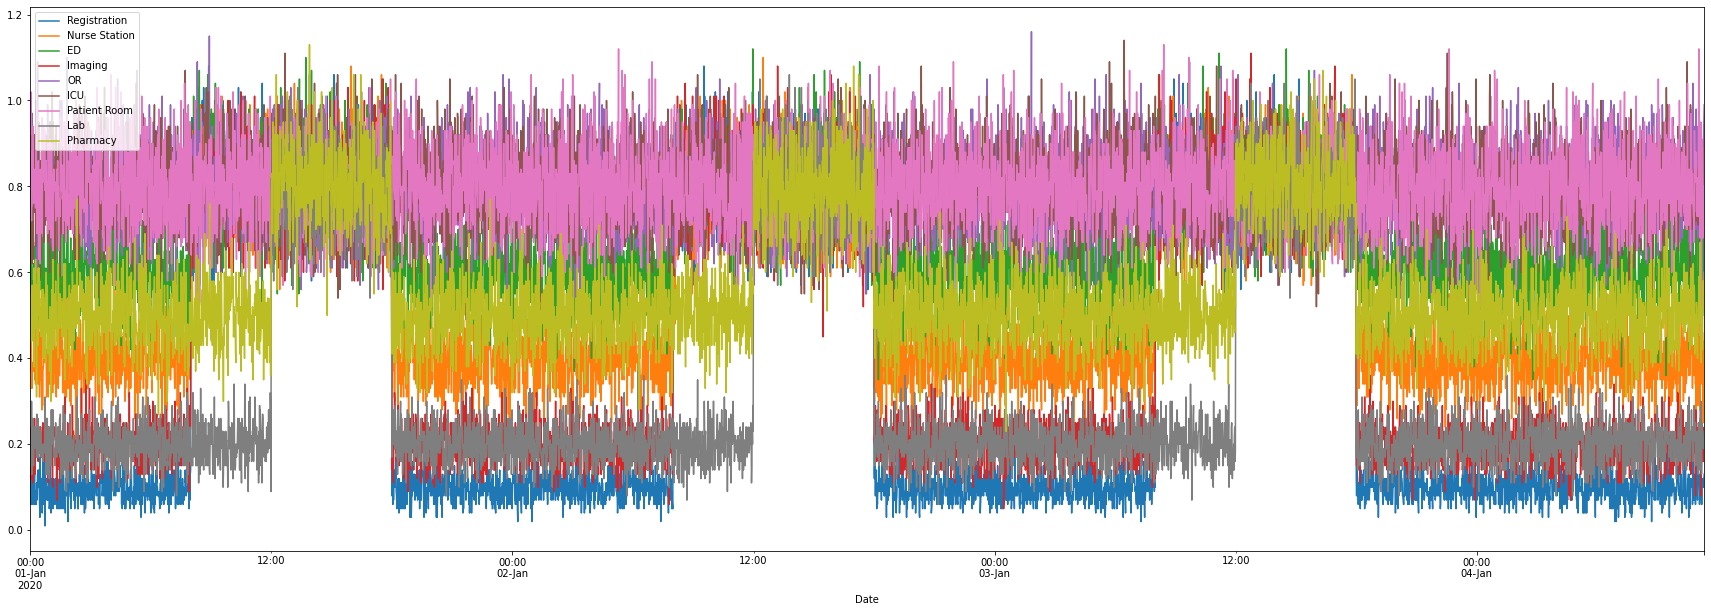

In [66]:
hospitalDataset[:5000].plot(y=hospitalDataset.columns,figsize=(30, 10))

In [73]:
hospitalDataset.head(2)

,Registration,Nurse Station,ED,Imaging,OR,ICU,Patient Room,Lab,Pharmacy,ComputeUtilized,Servermax,ServerComputeAvail
Date,,,,,,,,,,,,
2020-01-01 00:00:00,0.12,0.38,0.55,0.16,0.80,0.87,0.93,0.15,0.43,22.39,9,-13.39
2020-01-01 00:01:00,0.06,0.42,0.59,0.19,0.83,0.84,0.92,0.18,0.46,22.49,9,-13.49


## Calculating compute utilized and compute available

In [68]:
def addUtilization(df:pd.DataFrame,maxCompute=100):
    df['ComputeUtilized'] = df.sum(axis=1)
    df['Servermax'] = [maxCompute]*len(df)
    df['ServerComputeAvail'] = df['Servermax']-df['ComputeUtilized']

In [72]:
addUtilization(hospitalDataset,maxCompute=9)

<AxesSubplot:xlabel='Date'>

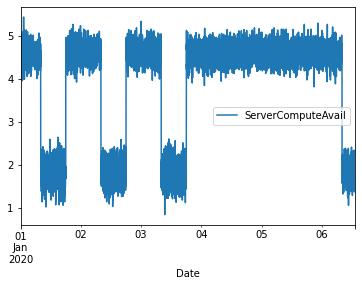

In [53]:
hospitalDataset[:8000].plot(y='ServerComputeAvail')

## Dataset for Transportation